![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# Legal Text Splitting

# 1. Splitting sentences in smaller pieces for token classification purposes (e.g, NER)

##  1.1. Background

Legal languages are usually `verbose`. Sentences have much more words than in conversational or informal versions of the language. Just take a look at this piece of text, extracted from a SEC 10-K filing.

> _Under Nevada law, we are prohibited from paying dividends if the distribution would result in our Company not being able to pay its debts as they become due in the normal course of business if our total assets would be less than the sum of our total liabilities plus the amount that would be needed to pay the dividends, or if we were to be dissolved at the time of distribution to satisfy the preferential rights upon dissolution of stockholders whose preferential rights are superior to those receiving the distribution._

Often times, you can find inline lists:

> _In addition to these objective standards, the NYSE American may delist the securities of any issuer (i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory; (ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable; (iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company; (iv) if an issuer fails to comply with the NYSE American’s listing requirements; (v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American; or (vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable._

And sometimes, very long enumerations...

> _On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”)_

... and what is worse, some of them combined.

> _On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agreement_


If reading those long sentences is already a challenge for humans, just imagine how challenging it may be for a machine. Let's talk about these restrictions.

## 1.2. About Out of Vocabulary and Subwording in Tokenization
The number of words in a vocabulary used in a transformer can't be infinite. Better to say, the number of `tokens`. A token is the smallest piece of text we woprk with, obtained after a `tokenization` process. 

`Tokenizing` means separating a sentence into these smaller pieces. In languages with words separated by white spaces, there are at least 3 ways to do that:



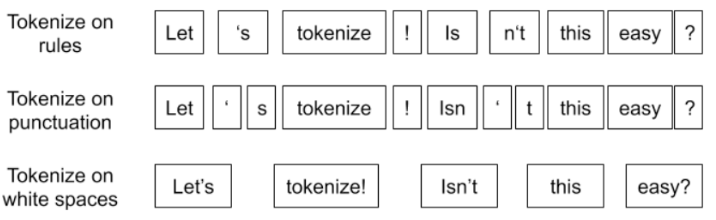

Let's simplify and think we just separate the tokens by using punctuation. In a sentence like:
`Let's tokenize! Isn't this easy?`

We would be getting:
`Let ' s tokenize ! Isn ' t this easy ?`

That's already 11 tokens to go to the vocabulary. The traditional way to build a vocabulary is was just that:
1) Tokenizing the corpus;
2) Getting each token;
3) Adding it to the vocabulary

**Problem**: languages may consist of 500K to 1M words, if we take into consideration different forms (is not, is, isn ' t ...) . That's something unbearable for real-time NLP architectures to cope with.

### 1.2.1. Out of Vocabulary

**1st solution**: OOV (Out of Vocabulary). The first ML/DL algorithms used to prune the vocabulary, leaving the top-N most frequent tokens seen in the corpus and discarding the rest

This approach soon run short, as the necesities to capture all the meaning of a text without discardign anything became crucial

### 1.2.2. Subword tokenization

The **2nd solution** is _subword tokenization_. The idea behind this is that we can split words into sequences of characters, if we see a probability of that sequence of characters being frequently used to form other words. For example, let's suppose we have the following sentence:

`My favourite Natural Language Processing library is clearly Spark NLP!`

The subword tokenization algorithm used by `BERT` transformers is called WordPiece. The result WordPiece returns for that sentence is:

```
['My', 'favourite', 'Natural', 'Language', 'Process', '##ing', 'library', 'is', 'clearly', 'Spa', '##rk', 'NL', '##P', '!']
```

As we can see, we got:
- `Processing` split into 2 subwords: `Process` and `##ing`. That's because `Process` seems a very common subword in the texts used to train BERT, and `ing` a very common subword (suffix) as well. The `##` means that subwords goes attached to the previous word (`Process`).
- `Spark` split into `Spa`(again, `Spa` is a common subword, for example, `Spa` in Wellness) and `##rk`
- `NLP` into `NL` and `#P`

As you have probably noticed, proper nouns are usually split in more than one subword, as also derivative words (Process - Process+ing).

This second approach is the most used in State of the Art NLP architectures, including in all the Spark NLP Transformers.

### 1.2.3. Length restriction of Transformers

If we thought that our legal sentences were already **long** by themselves, just think about how long they get after we carry out `subword` tokenization.

Transformers have restrictions in terms of the number of (subworded) tokens they can process, as shown in the list below. Any subsequent token after that limit of subwords will be discarded from the sentence.

| Transformer | Limit of tokens |
|-------------|-----------------|
| BERT        | 512             |
| XLNet       | 512             |
| RoBERTa     | 512             |
| XLM-RoBERTa | 512             |
| Electra     | 512             |
| Longformers*| 4096 (8 x BERT) |


As you can see, most of the transformers work with a token limit of 512. There are several exceptions, as Longformer and BigBird, which allow up to 4096.

## 1.3. Conclusions
In this notebook we will show you several techniques and their caveats to properly split Sentences so that you reduce your sentence length after tokenization.

Doing this has proved to be better even when you are within the limits of your sentence token length (512) - smaller chunks of pieces of text are better managed than long sequences.

## Setup

In [ ]:
from johnsnowlabs import *

import pandas as pd
import json
import os

spark = start_spark()

# 1. Sentence Splitting for Token Classification

There are two annotators you can find in Spark NLP> 
- SentenceDetector: a configurable, Rule-based sentence splitter.
- SentenceDetectorDL: a trainable, DL-based sentence splitter.

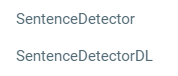

We will be focusing on how to test different splitting rule mechanisms with SentenceDetector, but you can also train your own SentenceDetectorDL by providing with manually split sentences (check the [SentenceDetectorDLApproach](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/9.SentenceDetectorDL.ipynb))

## Non-aggressive sentence splitting
Let's use several characters which don't drastically change the structure of the sentence. Check the documentation of the [SentenceDetector](https://nlp.johnsnowlabs.com/api/python/reference/autosummary/sparknlp/annotator/sentence/sentence_detector/index.html#sparknlp.annotator.sentence.sentence_detector.SentenceDetector).

In [2]:
text = """In addition to these objective standards, the NYSE American may delist the securities of any issuer (i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory; (ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable; (iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company; (iv) if an issuer fails to comply with the NYSE American’s listing requirements; (v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American; or (vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable. This is another sentence."""

For this case, just and additional tokenization by `;` with `.setCustomBounds` may suffice.

`.setCustomBounds`accepts a list of regular expressions to be used to split the sentence. By default, already containst he following:

```
Lists (“(i), (ii)”, “(a), (b)”, “1., 2.”)
Numbers
Abbreviations
Punctuations
Multiple Periods
Geo-Locations/Coordinates (“N°. 1026.253.553.”)
Ellipsis (”…”)
In-between punctuations
Quotation marks
Exclamation Points
Basic Breakers (“.”, “;”)
```

If you want to disable predefined expresions, use `.setUseCustomBoundsOnly(True)`. We will leave them.

In [3]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";"])\
    .setUseCustomBoundsOnly(False)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [4]:
lp = nlp.LightPipeline(model)

In [5]:
lp.annotate(text)['sentence']

['In addition to these objective standards, the NYSE American may delist the securities of any issuer',
 '(i) if, in its opinion, the issuer’s financial condition and/or operating results appear unsatisfactory',
 '(ii) if it appears that the extent of public distribution or the aggregate market value of the security has become so reduced as to make continued listing on the NYSE American inadvisable',
 '(iii) if the issuer sells or disposes of principal operating assets or ceases to be an operating company',
 '(iv) if an issuer fails to comply with the NYSE American’s listing requirements',
 '(v) if an issuer’s securities sell at what the NYSE American considers a “low selling price” which the exchange generally considers $0.20 per share and the issuer fails to correct this via a reverse split of shares after notification by the NYSE American',
 'or',
 '(vi) if any other event occurs or any condition exists which makes continued listing on the NYSE American, in its opinion, inadvisable.

For this case, additional tokenization on `;`, `:` with `.setCustomBounds` may suffice

In [6]:
text = 'Taiwan. Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters: "The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities."'

In [7]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";",":"])\
    .setUseCustomBoundsOnly(False)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


However, several quotes in a sentence may require a splitting by quotes. `;`, `"` with `.setCustomBounds`

In [8]:
text = 'Taiwan. Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters: "The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities.", and "there is no way we can restablish the communication in the next few months"'

In [9]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";","\""])\
    .setUseCustomBoundsOnly(False)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [10]:
lp = nlp.LightPipeline(model)

In [11]:
lp.annotate(text)['sentence']

['Taiwan.',
 'Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan, Foreign Ministry spokesman Shen Guofang told Reuters:',
 'The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities.',
 ', and',
 'there is no way we can restablish the communication in the next few months']

## Aggressive sentence-splitting
Sometimes the splitting with "conservative" techniques is not enough. In that case, you may considering breaking the sentence structure. 

This has the main caveat that you may lose context by breaking the sentence into smaller pieces.

However, if there is no other way you can split a sentence, it's better to lose some context but using all the words, than just not splitting and cutting off the sentence on the 512nd token.

Even when you are within the limits, sometimes splitting into smaller chunks helps the model repetitive patterns which may get deluded in big sentences.

Also, the performance degrades the longer the sentence is. Sometimes splitting in smaller sentences may provide with an performance improvement.

In [12]:
text = 'On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agreement"'

In [15]:
documentAssembler =nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds([";","\""])\
    .setUseCustomBoundsOnly(False)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [16]:
lp = nlp.LightPipeline(model)

**Conservative splitting does not help**

In [17]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”), and CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”), and (2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger A

**Splitting by parethensis**

In [18]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setCustomBounds(["\(","\)"])\
    .setUseCustomBoundsOnly(False)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [19]:
lp = nlp.LightPipeline(model)

In [20]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement',
 'the “Merger Termination Agreement”',
 'with ConversionPoint Technologies Inc., a Delaware corporation',
 '“CPT”',
 ', ConversionPoint Holdings, Inc., a Delaware corporation',
 '“Parent”',
 ', CPT Merger Sub, Inc., a Delaware corporation,',
 '“CPT Merger Sub”',
 ', and CPT Cigar Merger Sub, Inc., a Nevada corporation',
 '“Inuvo Merger Sub”',
 'which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub, and Inuvo Merger Sub, as amended',
 'the “Merger Agreement”',
 ', pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent, and CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent',
 'the “Mergers”',
 ', and',
 '2',
 'terminated each of the Support Agreements that were entered into by certain officers a

We can use **REGEX** or just several characters in a row in our `setCustomBounds`to be able to have finegrain splits.

In [21]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")\
    .setUseCustomBoundsOnly(False)\
    .setCustomBounds([", and"])

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [22]:
lp = nlp.LightPipeline(model)

In [23]:
lp.annotate(text)['sentence']

['On June 20, 2019, Inuvo entered into an Agreement and Plan of Merger Termination Agreement (the “Merger Termination Agreement”) with ConversionPoint Technologies Inc., a Delaware corporation (“CPT”), ConversionPoint Holdings, Inc., a Delaware corporation (“Parent”), CPT Merger Sub, Inc., a Delaware corporation, (“CPT Merger Sub”)',
 'CPT Cigar Merger Sub, Inc., a Nevada corporation (“Inuvo Merger Sub”) which, among other things, terminated the Agreement and Plan of Merger, dated November 2, 2018, by and among Inuvo, CPT, Parent, CPT Merger Sub',
 'Inuvo Merger Sub, as amended (the “Merger Agreement”), pursuant to which Inuvo would have merged with and into Inuvo Merger Sub and become a wholly-owned subsidiary of Parent',
 'CPT would have merged with and into CPT Merger Sub and become a wholly-owned subsidiary of Parent (the “Mergers”)',
 '(2) terminated each of the Support Agreements that were entered into by certain officers and directors of Inuvo and the parties to the Merger Agree

# 2. Mergin sentences together for Paragraph / Clause classification

## 2.1. Background
The opposite use case is when you want to carry out Text Classification but only of certain pieces of the document. A good example of it it's Clauses Extraction or Clauses Identification in Legal Documents.

There are several ways we can carry out Text Classification:

1) `At a whole-text level`: That's not feasible for most legal documents. As we already know, we have a 512 token estriction for most BERT-based thansformers. We can use Longformers or BigBird, but in most cases, Legal documents have many pages, what will go for sure beyond any limitation.

2) `Using sentence-splitting`: That will definitely split the document at smaller chunks, but often times, the meaning will be contained inside a paragraph level (multisentence lever).

3) `Using a multiline splitting`: We can create our own rules not not split by `\n` or stopping characters like `.` but, for example, by headers, subheaders or even multiple lines.

In [24]:
text = """Exhibit 10.2

Execution Version

INTELLECTUAL PROPERTY AGREEMENT

This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC, a Delaware limited liability company ("Licensing" and together with Seller, "Arizona") and AHF Holding, Inc. (formerly known as Tarzan HoldCo, Inc.), a Delaware corporation ("Buyer") and Armstrong Hardwood Flooring Company, a Tennessee corporation (the "Company" and together with Buyer the "Buyer Entities") (each of Arizona on the one hand and the Buyer Entities on the other hand, a "Party" and collectively, the "Parties").

WHEREAS, Seller and Buyer have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement"); WHEREAS, pursuant to the Stock Purchase Agreement, Seller has agreed to sell and transfer, and Buyer has agreed to purchase and acquire, all of Seller's right, title and interest in and to Armstrong Wood Products, Inc., a Delaware corporation ("AWP") and its Subsidiaries, the Company and HomerWood Hardwood Flooring Company, a Delaware corporation ("HHFC," and together with the Company, the "Company Subsidiaries" and together with AWP, the "Company Entities" and each a "Company Entity") by way of a purchase by Buyer and sale by Seller of the Shares, all upon the terms and condition set forth therein;"""

**We will set custom Bounds to False to force ignoring `.` and `\n`, but adding `\n\n` as a paragraph separator**

In [25]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
paragraphDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("paragraph")\
    .setUseCustomBoundsOnly(False)\
    .setCustomBounds(["\n\n"])\
    .setUseCustomBoundsOnly(True)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        paragraphDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)


In [26]:
lp = nlp.LightPipeline(model)

In [27]:
lp.annotate(text)['paragraph']

['Exhibit 10.2',
 'Execution Version',
 'INTELLECTUAL PROPERTY AGREEMENT',
 'This INTELLECTUAL PROPERTY AGREEMENT (this "Agreement"), dated as of December 31, 2018 (the "Effective Date") is entered into by and between Armstrong Flooring, Inc., a Delaware corporation ("Seller") and AFI Licensing LLC, a Delaware limited liability company ("Licensing" and together with Seller, "Arizona") and AHF Holding, Inc. (formerly known as Tarzan HoldCo, Inc.), a Delaware corporation ("Buyer") and Armstrong Hardwood Flooring Company, a Tennessee corporation (the "Company" and together with Buyer the "Buyer Entities") (each of Arizona on the one hand and the Buyer Entities on the other hand, a "Party" and collectively, the "Parties").',
 'WHEREAS, Seller and Buyer have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement"); WHEREAS, pursuant to the Stock Purchase Agreement, Seller has agreed to sell and transfer, and Buyer has agreed to purchase an

In [28]:
lp.annotate(text)['paragraph'][4]

'WHEREAS, Seller and Buyer have entered into that certain Stock Purchase Agreement, dated November 14, 2018 (the "Stock Purchase Agreement"); WHEREAS, pursuant to the Stock Purchase Agreement, Seller has agreed to sell and transfer, and Buyer has agreed to purchase and acquire, all of Seller\'s right, title and interest in and to Armstrong Wood Products, Inc., a Delaware corporation ("AWP") and its Subsidiaries, the Company and HomerWood Hardwood Flooring Company, a Delaware corporation ("HHFC," and together with the Company, the "Company Subsidiaries" and together with AWP, the "Company Entities" and each a "Company Entity") by way of a purchase by Buyer and sale by Seller of the Shares, all upon the terms and condition set forth therein;'

**By headers**

In [29]:
text = """
4. GRANT OF KNOW-HOW LICENSE 
4.1 Arizona Know-How Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non- exclusive, royalty-free license in, to and under the Arizona Licensed Know-How for use in the Company Field throughout the world. 
4.2 Company Know-How Grant. Subject to the terms and conditions of this Agreement, the Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license in, to and under the Company Licensed Know-How for use in the Arizona Field throughout the world. 
5. GRANT OF PATENT LICENSE 
5.1 Arizona Patent Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non-exclusive, royalty-free license in, to and under the Arizona Licensed Patents for use in the Company Field throughout the world.
"""

In [30]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
paragraphDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("paragraph")\
    .setCustomBounds(["\n\d\. "])\
    .setCustomBoundsStrategy('prepend')\
    .setUseCustomBoundsOnly(True)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        paragraphDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)

lp = nlp.LightPipeline(model)


In [31]:
lp.annotate(text)['paragraph']

['4. GRANT OF KNOW-HOW LICENSE \n4.1 Arizona Know-How Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non- exclusive, royalty-free license in, to and under the Arizona Licensed Know-How for use in the Company Field throughout the world. \n4.2 Company Know-How Grant. Subject to the terms and conditions of this Agreement, the Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license in, to and under the Company Licensed Know-How for use in the Arizona Field throughout the world.',
 '5. GRANT OF PATENT LICENSE \n5.1 Arizona Patent Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non-exclusive, royalty-free license in, to and under the Arizona Licensed Patents for use in the Company Field throughout the world.']

**By subheader**

In [32]:
text = """
4. GRANT OF KNOW-HOW LICENSE 
4.1 Arizona Know-How Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non- exclusive, royalty-free license in, to and under the Arizona Licensed Know-How for use in the Company Field throughout the world. 
4.2 Company Know-How Grant. Subject to the terms and conditions of this Agreement, the Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license in, to and under the Company Licensed Know-How for use in the Arizona Field throughout the world. 
5. GRANT OF PATENT LICENSE 
5.1 Arizona Patent Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non-exclusive, royalty-free license in, to and under the Arizona Licensed Patents for use in the Company Field throughout the world.
"""

In [33]:
documentAssembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")
        
paragraphDetector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("paragraph")\
    .setCustomBounds(["\n[\d\.]+"])\
    .setCustomBoundsStrategy('prepend')\
    .setUseCustomBoundsOnly(True)

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        paragraphDetector])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)

lp = nlp.LightPipeline(model)


In [34]:
lp.annotate(text)['paragraph']

['4. GRANT OF KNOW-HOW LICENSE',
 '4.1 Arizona Know-How Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non- exclusive, royalty-free license in, to and under the Arizona Licensed Know-How for use in the Company Field throughout the world.',
 '4.2 Company Know-How Grant. Subject to the terms and conditions of this Agreement, the Company hereby grants to Seller a perpetual, non- exclusive, royalty-free license in, to and under the Company Licensed Know-How for use in the Arizona Field throughout the world.',
 '5. GRANT OF PATENT LICENSE',
 '5.1 Arizona Patent Grant. Subject to the terms and conditions of this Agreement, Arizona hereby grants to the Company a perpetual, non-exclusive, royalty-free license in, to and under the Arizona Licensed Patents for use in the Company Field throughout the world.']

# 3. Headers and Subheaders
We have a model which is able to understand headers and subheaders in legal documents.

It's an NER model we can use at sentence level, to detect if there is a header (X. HEADER) or a subheader (X.X. Subheader) in a text.

We can use then the headers and subheaders to infer the sections of the document, as shown in the code below.

In [ ]:
documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")
        
sentenceDetector = nlp.SentenceDetectorDLModel.pretrained("sentence_detector_dl","xx")\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner_model = legal.NerModel.pretrained("legner_headers", "en", "legal/models")\
        .setInputCols(["sentence", "token", "embeddings"])\
        .setOutputCol("ner")

ner_converter = nlp.NerConverter()\
        .setInputCols(["sentence","token","ner"])\
        .setOutputCol("ner_chunk")

nlp_pipeline = nlp.Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        embeddings,
        ner_model,
        ner_converter])

In [38]:
text = """AGREEMENT

NOW, THEREFORE, for good and valuable consideration, and in consideration of the mutual covenants and conditions herein contained, the Parties agree as follows:

2. Definitions. For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1. 2. Appointment as Reseller.

2.1 Appointment. The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6

2.2 Customer Agreements.

a) Subscriptions. Allscripts and its Affiliates may sell Subscriptions for terms no less than one year and no greater than four (4) years on a subscription basis to Persons who subsequently execute a Customer Agreement, provided that Allscripts may enter into Customer Agreements with terms longer than four (4) years with large organizations, provided that Phreesia consents in each instance in writing in advance, which consent will not be unreasonably withheld."""

In [ ]:
empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlp_pipeline.fit(empty_data)

lp = nlp.LightPipeline(model)

result = lp.fullAnnotate(text)[0]['ner_chunk'] # Document 0

In [42]:
result

[Annotation(chunk, 0, 8, AGREEMENT, {'entity': 'HEADER', 'sentence': '0', 'chunk': '0', 'confidence': '0.8845'}),
 Annotation(chunk, 173, 186, 2. Definitions, {'entity': 'HEADER', 'sentence': '1', 'chunk': '1', 'confidence': '0.9994667'}),
 Annotation(chunk, 295, 320, 2. Appointment as Reseller, {'entity': 'HEADER', 'sentence': '2', 'chunk': '2', 'confidence': '0.9742999'}),
 Annotation(chunk, 324, 338, 2.1 Appointment, {'entity': 'SUBHEADER', 'sentence': '3', 'chunk': '3', 'confidence': '0.99995'}),
 Annotation(chunk, 698, 720, 2.2 Customer Agreements, {'entity': 'SUBHEADER', 'sentence': '6', 'chunk': '4', 'confidence': '0.9999333'}),
 Annotation(chunk, 724, 739, a) Subscriptions, {'entity': 'SUBHEADER', 'sentence': '7', 'chunk': '5', 'confidence': '0.9998'})]

In [43]:
sections = []
for ann in result:
    sections.append( (ann.begin, ann.end) )
sections

[(0, 8), (173, 186), (295, 320), (324, 338), (698, 720), (724, 739)]

In [44]:
section_texts = []
last_section = 0
last_section_name = ""
for s in sections:
    t = last_section_name + text[last_section:s[0]]
    if t != '':
        section_texts.append(t)  
    last_section = s[1]+1
    last_section_name = text[s[0]:s[1]+1]
section_texts.append(last_section_name + text[last_section:s[0]])  


In [45]:
OKGREEN = '\033[92m'
ENDC = '\033[0m'

In [46]:
for t in section_texts:
    print(f"{OKGREEN}SECTION:{ENDC}\n{t}")

SECTION:
AGREEMENT

NOW, THEREFORE, for good and valuable consideration, and in consideration of the mutual covenants and conditions herein contained, the Parties agree as follows:


SECTION:
2. Definitions. For purposes of this Agreement, the following terms have the meanings ascribed thereto in this Section 1. 
SECTION:
2. Appointment as Reseller.


SECTION:
2.1 Appointment. The Company hereby [***]. Allscripts may also disclose Company's pricing information relating to its Merchant Processing Services and facilitate procurement of Merchant Processing Services on behalf of Sublicensed Customers, including, without limitation by references to such pricing information and Merchant Processing Services in Customer Agreements. 6


SECTION:
2.2 Customer Agreements.


SECTION:
a) Subscriptions
